In [1]:
import pandas as pd
import numpy as np
import struct, gzip, matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['font.size'] = 12

In [2]:
def tiff_to_centroid_np(tif_path):
    with open(tif_path, 'rb') as f:
        f.seek(0, 2)
        file_bytes = f.tell() - 8
        f.seek(8)
        raw = f.read(file_bytes)
        if raw[:2] == b'\x1f\x8b':
            raw = gzip.decompress(raw)
        height = 1400
        width  = len(raw) // height
        raw = raw[:width * height]
        band1 = np.frombuffer(raw, dtype=np.uint8).reshape(height, width)
    # 硬编码 GeoTransform
    ulat, ulon = 53.5, 121.0
    res = 0.008333
    nodata = 0
    rows, cols = np.where(band1 != nodata)
    doy = band1[rows, cols]
    lat = ulat - (rows + 0.5) * res
    lon = ulon + (cols + 0.5) * res
    return lat, lon, doy

In [13]:
maize_lat, maize_lon, maize_doy = tiff_to_centroid_np('Heilongjiang_Maize_MA_2010.tif')
wheat_lat, wheat_lon, wheat_doy = tiff_to_centroid_np('Heilongjiang_Wheat_MA_2010.tif')
crop_lat = np.concatenate([maize_lat, wheat_lat])
crop_lon = np.concatenate([maize_lon, wheat_lon])
print('Total number of crop pixels：', crop_lat.size)

Total number of crop pixels： 497110


In [12]:
county_boxes = {
    'Harbin':     {'lat_min':45.0, 'lat_max':46.5, 'lon_min':125.0, 'lon_max':128.0},
    'Daqing':     {'lat_min':45.5, 'lat_max':47.0, 'lon_min':123.5, 'lon_max':126.0},
    'Qiqihar':    {'lat_min':46.5, 'lat_max':48.5, 'lon_min':122.5, 'lon_max':125.5},
    'Suihua':     {'lat_min':46.0, 'lat_max':48.0, 'lon_min':125.0, 'lon_max':128.0},
    'Jiamusi':    {'lat_min':46.0, 'lat_max':48.0, 'lon_min':129.0, 'lon_max':134.0},
    'Mudanjiang': {'lat_min':43.5, 'lat_max':46.0, 'lon_min':128.0, 'lon_max':131.5},
    'Jixi':       {'lat_min':44.5, 'lat_max':46.5, 'lon_min':130.0, 'lon_max':134.0},
    'Hegang':     {'lat_min':46.5, 'lat_max':48.0, 'lon_min':129.5, 'lon_max':131.0},
    'Shuangyashan':{'lat_min':45.5, 'lat_max':47.5, 'lon_min':130.0, 'lon_max':134.0},
    'Qitaihe':    {'lat_min':45.0, 'lat_max':46.5, 'lon_min':129.0, 'lon_max':132.0},
    'Heihe':      {'lat_min':48.0, 'lat_max':51.0, 'lon_min':124.0, 'lon_max':129.0},
    'Daxinganling':{'lat_min':50.0, 'lat_max':53.5, 'lon_min':121.0, 'lon_max':126.0},
    'Yichun':     {'lat_min':46.5, 'lat_max':49.5, 'lon_min':127.0, 'lon_max':131.0}
}

def which_box(lat, lon):
    for name, box in county_boxes.items():
        if (box['lat_min'] <= lat <= box['lat_max'] and
            box['lon_min'] <= lon <= box['lon_max']):
            return name
    return None

crop_df = pd.DataFrame({'lat':crop_lat, 'lon':crop_lon})
crop_df['county'] = crop_df.apply(lambda row: which_box(row['lat'], row['lon']), axis=1)
crop_area = crop_df['county'].value_counts()
print('Crop pixels by county：\n', crop_area)

Crop pixels by county：
 Daxinganling    146456
Qiqihar           4022
Name: county, dtype: int64


In [5]:
fires = pd.read_csv('hlj_fires_2010_2019.csv')
fires['county'] = fires.apply(lambda row: which_box(row['latitude'], row['longitude']), axis=1)
fires = fires[fires['county'].notnull()]
print('火点分配到县：', fires.shape[0])

火点分配到县： 226322


In [6]:
yearly_fire = fires.groupby(['county','year']).size().reset_index(name='fire_cnt')
yearly_fire = yearly_fire.merge(crop_area.rename('crop_px').reset_index(),
                                left_on='county', right_on='index')
yearly_fire['burn_rate'] = yearly_fire['fire_cnt'] / yearly_fire['crop_px'] * 1000

In [7]:
def trend_theil_mk(y):
    t = np.arange(len(y))
    slope, _, _, _ = stats.theilslopes(y, t, 0.95)
    _, p = stats.mstats.kendalltau(t, y)
    return slope, p

trend_tab = yearly_fire.pivot_table(values='burn_rate', index='year', columns='county')
trend_res = []
for county in trend_tab.columns:
    y = trend_tab[county].dropna().values
    if len(y) >= 6:
        slope, p = trend_theil_mk(y)
        trend_res.append({'county':county, 'slope':slope, 'p':p})
trend_df = pd.DataFrame(trend_res)

In [8]:
all_counties = set(crop_area.index)
sig_counties = set(trend_df['county'])
missing = all_counties - sig_counties
trend_df = trend_df.append(
    pd.DataFrame({'county': list(missing), 'slope': 0.0, 'p': 1.0}),
    ignore_index=True)

def color_rule(row):
    if row['p'] >= 0.05:
        return 'lightgray'
    return 'royalblue' if row['slope'] < 0 else 'firebrick'

trend_df['color'] = trend_df.apply(color_rule, axis=1)
trend_df.sort_values('slope', inplace=True)

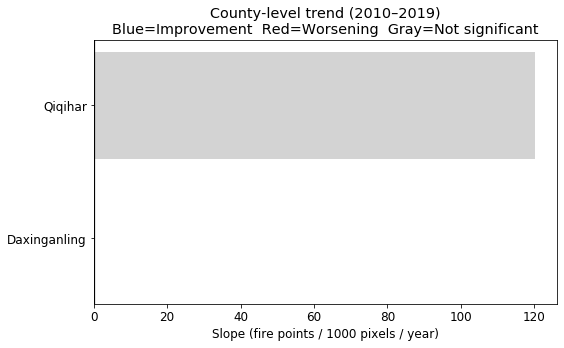

In [9]:
plt.figure(figsize=(8, 5))
plt.barh(trend_df['county'], trend_df['slope'], color=trend_df['color'])
plt.axvline(0, color='black', lw=1.2)
plt.xlabel('Slope (fire points / 1000 pixels / year)')
plt.title('County-level trend (2010–2019)\nBlue=Improvement  Red=Worsening  Gray=Not significant')
plt.tight_layout(); plt.show()

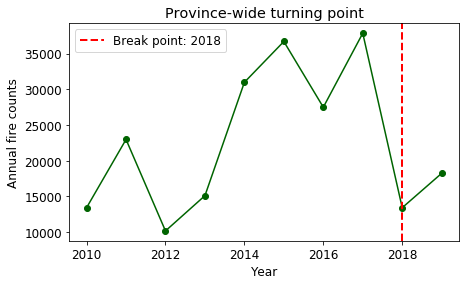

Key points and turning points of fires across the province：2018


In [11]:
prov_year = fires.groupby('year').size().reset_index(name='fire_cnt')

y = prov_year['fire_cnt'].values
x = np.arange(len(y))
d = np.abs(np.diff(y))
bkpt = np.argmax(d) + 1
break_year = 2010 + bkpt

plt.figure(figsize=(7, 4))
plt.plot(prov_year['year'], y, marker='o', color='darkgreen')
plt.axvline(break_year, color='red', linestyle='--', lw=2,
            label=f'Break point: {break_year}')
plt.ylabel('Annual fire counts'); plt.xlabel('Year')
plt.title('Province-wide turning point')
plt.legend(); plt.show()
print(f'Key points and turning points of fires across the province：{break_year}')

In [14]:
trend_df.to_csv('county_trend_2010_2019.csv', index=False)
print('county_trend_2010_2019.csv has been saved')

county_trend_2010_2019.csv has been saved
